In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import requests
import json

# Handle dates and times in our bike data
from datetime import datetime, timedelta

# Track processing time - might need this for large datasets
import time

In [ ]:
# Configure visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.mode.chained_assignment = None  # Suppress warnings

In [ ]:
# Fetch station data
print("Fetching station data from TfL API...")

base_url = "https://api.tfl.gov.uk/BikePoint"
try:
    # Get all bike stations
    response = requests.get(base_url)
    if response.status_code == 200:
        stations = response.json()
        print(f"Successfully fetched data for {len(stations)} bike stations")
    else:
        print(f"Error fetching data: Status code {response.status_code}")
except Exception as e:
    print(f"Something went wrong: {str(e)}")


Fetching station data from TfL API...
Successfully fetched data for 796 bike stations


In [ ]:
# Explore API data
print("\nFields in the dataset:")
for key in stations[0].keys():
    print(f": {key}")


Fields in the dataset:
: $type
: id
: url
: commonName
: placeType
: additionalProperties
: children
: childrenUrls
: lat
: lon


In [ ]:
# Check values from a sample station
if stations:
    sample_station = stations[0]
    print("Sample station data:")
    for key, value in sample_station.items():
        print(f"{key}: {value}")

Sample station data:
$type: Tfl.Api.Presentation.Entities.Place, Tfl.Api.Presentation.Entities
id: BikePoints_1
url: /Place/BikePoints_1
commonName: River Street , Clerkenwell
placeType: BikePoint
additionalProperties: [{'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Description', 'key': 'TerminalName', 'sourceSystemKey': 'BikePoints', 'value': '001023', 'modified': '2024-11-30T01:22:55.483Z'}, {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Description', 'key': 'Installed', 'sourceSystemKey': 'BikePoints', 'value': 'true', 'modified': '2024-11-30T01:22:55.483Z'}, {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Description', 'key': 'Locked', 'sourceSystemKey': 'BikePoints', 'value': 'false', 'modified': '2024-11-30T01:22:55.483Z'}, {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Present

In [ ]:
# Explore Additional Properties
print("\nadditionalProperties:")
for prop in sample_station['additionalProperties']:
    print(f"Property: {prop['key']} = {prop['value']}")


additionalProperties:
Property: TerminalName = 001023
Property: Installed = true
Property: Locked = false
Property: InstallDate = 1278947280000
Property: RemovalDate = 
Property: Temporary = false
Property: NbBikes = 17
Property: NbEmptyDocks = 1
Property: NbDocks = 19
Property: NbStandardBikes = 11
Property: NbEBikes = 6


To-Do:
1. Selected the target attributes needed for the project
2. Create a copy with the target attributes
2. Running further analysis on the copy of the dataset

In [ ]:
# Create a copy of the dataset for exploration
stations_list = []
for station in stations:
    # Store basic info, .get() for safety
    station_info = {
        'station_id': station.get('id', 'unknown').replace('BikePoints_', ''),
        'name': station.get('commonName', 'unnamed'),
        'latitude': station.get('lat', None),
        'longitude': station.get('lon', None)
    }
    stations_list.append(station_info)

df_stations = pd.DataFrame(stations_list)

In [ ]:
# Attribute Characteristics
for column in df_stations.columns:
    print(f"\nAttribute: {column}")
    print(f"Type: {df_stations[column].dtype}")
    print(f"% Missing Values: {df_stations[column].isnull().mean() * 100:.2f}%")
    if df_stations[column].dtype in ['int64', 'float64']:
        print(f"Min: {df_stations[column].min()}, Max: {df_stations[column].max()}")
        print(f"Mean: {df_stations[column].mean()}, Std: {df_stations[column].std()}")
    elif df_stations[column].dtype == 'object':
        print(f"Unique Values: {df_stations[column].nunique()}" )



Attribute: station_id
Type: object
% Missing Values: 0.00%
Unique Values: 796

Attribute: name
Type: object
% Missing Values: 0.00%
Unique Values: 796

Attribute: latitude
Type: float64
% Missing Values: 0.00%
Min: 51.454752, Max: 51.549369
Mean: 51.50594346482412, Std: 0.02025694532889584

Attribute: longitude
Type: float64
% Missing Values: 0.00%
Min: -0.236769, Max: -0.002275
Mean: -0.12755534296482413, Std: 0.05521663918635113


In [ ]:
# station_id is object data type, convert to int for future use
df_stations['station_id'] = pd.to_numeric(df_stations['station_id'], errors='coerce')
df_stations.dropna(subset=['station_id'], inplace=True)
df_stations['station_id'] = df_stations['station_id'].astype(int)

#check station_id
print(f"station_id:  {df_stations['station_id'].dtype}")

station_id:  int64


In [ ]:
# Remove spaces and convert names to lowercase
print("\nPerforming consistency check for station names...")
df_stations['name'] = df_stations['name'].str.strip().str.lower()


Performing consistency check for station names...


In [ ]:
# Detect outliers
lat_bounds = (51.3, 51.6)  # Expected range for London
lon_bounds = (-0.3, 0.1)

# Flag outliers
df_stations['latitude_outlier'] = ~df_stations['latitude'].between(lat_bounds[0], lat_bounds[1])
df_stations['longitude_outlier'] = ~df_stations['longitude'].between(lon_bounds[0], lon_bounds[1])

# Reporting outliers
lat_outliers = df_stations[df_stations['latitude_outlier']]
lon_outliers = df_stations[df_stations['longitude_outlier']]
print(f"Total Latitude Outliers: {lat_outliers.shape[0]}")
print(f"Total Longitude Outliers: {lon_outliers.shape[0]}")

Total Latitude Outliers: 0
Total Longitude Outliers: 0


In [ ]:
# Remove outlier flags
df_stations.drop(columns=['latitude_outlier', 'longitude_outlier'], inplace=True)

### Adding Historical Weather Data

In [ ]:
# Define API details
weather_api_url = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
api_key = "523cd7e829d74550a3013513243011"

# Set location and date range
location = "London,UK"
start_date = "2019-01-01"
end_date = "2019-12-31"

# Fetch weather data
params = {
    'q': location,
    'date': start_date,
    'enddate': end_date,
    'tp': 3,  # 3-hour interval
    'format': 'json',
    'key': api_key
}

try:
    response = requests.get(weather_api_url, params=params)
    if response.status_code == 200:
        weather_data = response.json()
        print("Successfully fetched historical weather data")
        # Save weather data for processing
        with open("weather_data.json", "w") as outfile:
            json.dump(weather_data, outfile)
    else:
        print(f"Error fetching weather data: Status code {response.status_code}")
except Exception as e:
    print(f"Error: {str(e)}")


Successfully fetched historical weather data


In [ ]:
# Parsing weather data into a DataFrame
def parse_weather_data(weather_data):
    # Extract relevant data from JSON response
    all_weather_data = []
    for day_data in weather_data['data']['weather']:
        date = day_data['date']
        for hourly_data in day_data['hourly']:
            all_weather_data.append({
                'date': date,
                'time': int(hourly_data['time']),
                'temperature_c': float(hourly_data['tempC']),
                'precipitation_mm': float(hourly_data['precipMM']),
                'humidity': int(hourly_data['humidity']),
                'wind_speed_kph': int(hourly_data['windspeedKmph']),
                'weather_desc': hourly_data['weatherDesc'][0]['value']
            })
    return pd.DataFrame(all_weather_data)

In [ ]:
# Load and process weather data
try:
    with open("weather_data.json", "r") as infile:
        raw_weather_data = json.load(infile)
        df_weather = parse_weather_data(raw_weather_data)
        print("Weather DataFrame created successfully!")
        print(df_weather.head())
except FileNotFoundError:
    print("Weather data file not found. Ensure data fetching is successful.")

Weather DataFrame created successfully!
         date  time  temperature_c  precipitation_mm  humidity  \
0  2019-01-01     0            9.0               0.0        78   
1  2019-01-01   300            6.0               0.0        85   
2  2019-01-01   600            7.0               0.0        88   
3  2019-01-01   900            7.0               0.0        88   
4  2019-01-01  1200            9.0               0.0        81   

   wind_speed_kph   weather_desc  
0              10       Overcast  
1              11  Partly cloudy  
2              12          Sunny  
3              13  Partly cloudy  
4              15  Partly cloudy  


In [ ]:
# Basic statistics and data quality check
print("\nWeather Data Overview:")
print(df_weather.info())
print("\nBasic Statistics:")
print(df_weather.describe())


Weather Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              280 non-null    object 
 1   time              280 non-null    int64  
 2   temperature_c     280 non-null    float64
 3   precipitation_mm  280 non-null    float64
 4   humidity          280 non-null    int64  
 5   wind_speed_kph    280 non-null    int64  
 6   weather_desc      280 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 15.4+ KB
None

Basic Statistics:
              time  temperature_c  precipitation_mm    humidity  \
count   280.000000     280.000000        280.000000  280.000000   
mean   1050.000000       4.496429          0.046429   78.142857   
std     688.617128       2.909628          0.186232   10.080729   
min       0.000000      -2.000000          0.000000   49.000000   
25%     525.000000       2.

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df_weather.isnull().sum())


Missing Values:
date                0
time                0
temperature_c       0
precipitation_mm    0
humidity            0
wind_speed_kph      0
weather_desc        0
dtype: int64


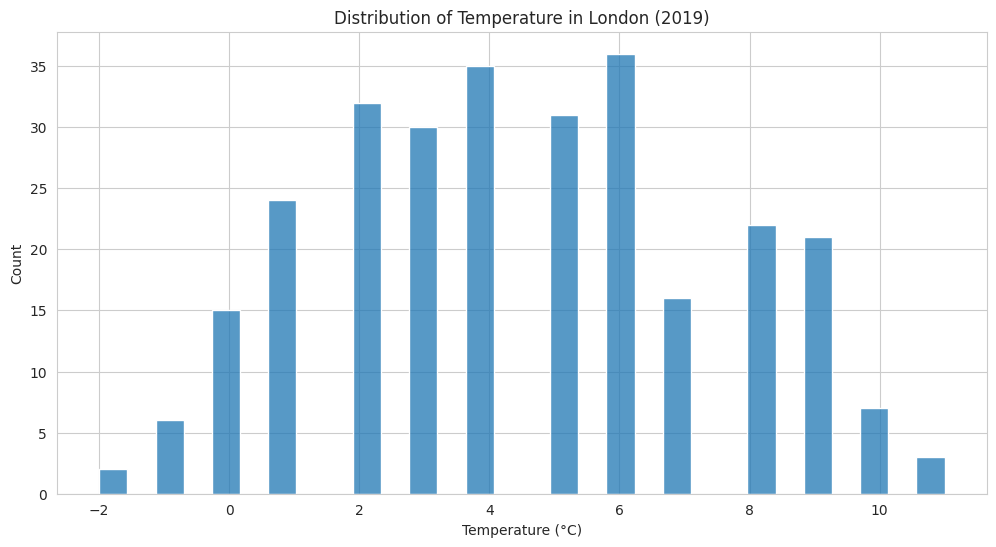

In [ ]:
# Temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_weather, x='temperature_c', bins=30)
plt.title('Distribution of Temperature in London (2019)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Count')
plt.show()

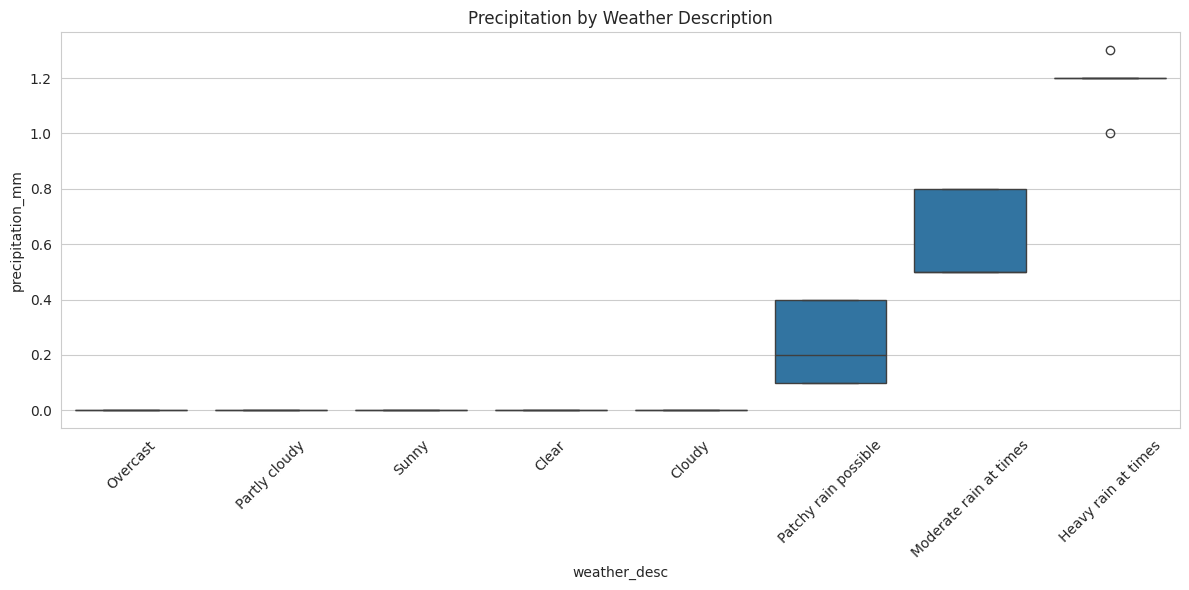

In [ ]:
# Precipitation patterns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_weather, x='weather_desc', y='precipitation_mm')
plt.xticks(rotation=45)
plt.title('Precipitation by Weather Description')
plt.tight_layout()
plt.show()

In [ ]:
# Monthly weather patterns
df_weather['month'] = pd.to_datetime(df_weather['date']).dt.month
monthly_weather = df_weather.groupby('month').agg({
    'temperature_c': 'mean',
    'precipitation_mm': 'mean',
    'humidity': 'mean',
    'wind_speed_kph': 'mean'
}).round(2)

print("\nMonthly Weather Patterns:")
print(monthly_weather)


Monthly Weather Patterns:
       temperature_c  precipitation_mm  humidity  wind_speed_kph
month                                                           
1               4.67              0.03     77.53           13.32
2               3.16              0.17     82.88           17.25


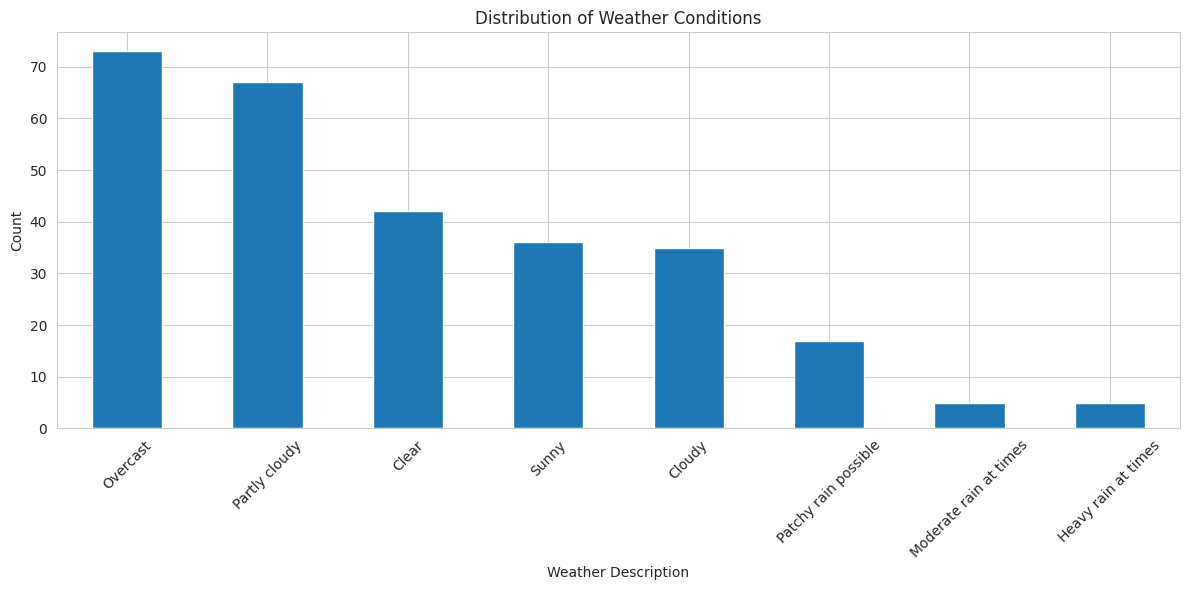

In [ ]:
# Weather description distribution
plt.figure(figsize=(12, 6))
df_weather['weather_desc'].value_counts().plot(kind='bar')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

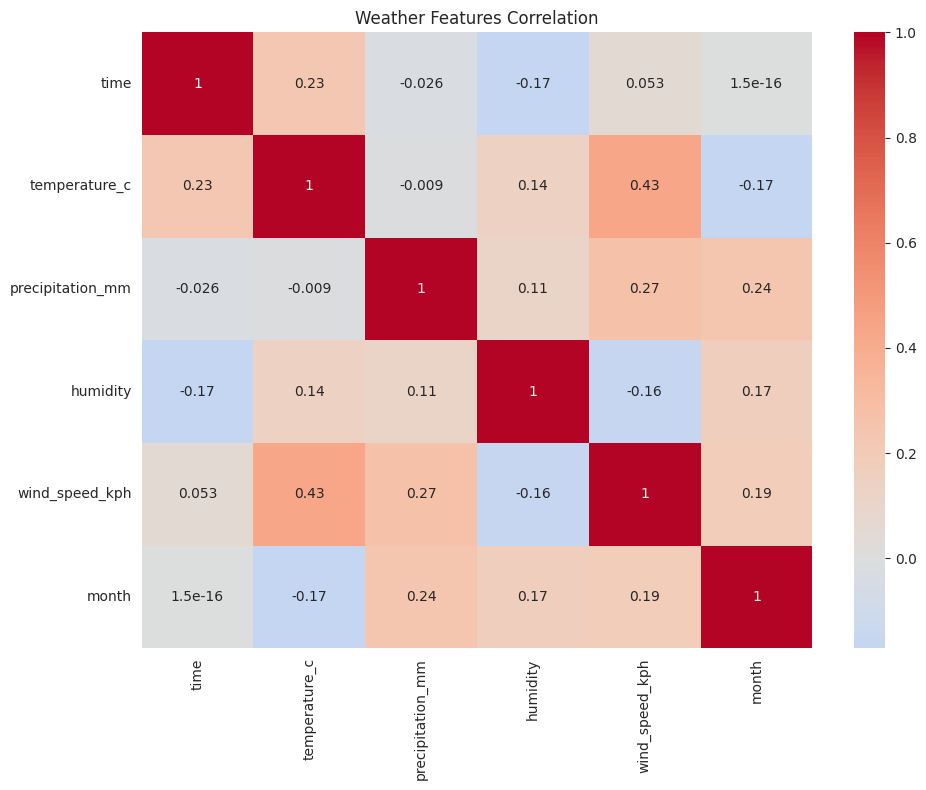

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_weather.select_dtypes(include=[np.number]).corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Weather Features Correlation')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#access the downloaded dataset files in google drive
data_folder = '/content/drive/MyDrive/Colab Notebooks/ML Project/Tfl journey datasets 2019'

all_data = []

# Loop through each file in the folder
for file in os.listdir(data_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(data_folder, file)
        # Load CSV as dataframe
        df = pd.read_csv(file_path)
        # Append it to list
        all_data.append(df)

# Combine all DataFrames into one
df_historical = pd.concat(all_data, ignore_index=True)

# Preview the combined DataFrame
print(f"Total rows in combined data: {df_historical.shape[0]}")
print(df_historical.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total rows in combined data: 10296186
   Rental Id  Duration  Bike Id          End Date  EndStation Id  \
0   83284852       660     8282  02/01/2019 17:47             94   
1   83360769       180     4657  06/01/2019 18:14             94   
2   83280311       960     6306  02/01/2019 14:49            374   
3   83323626       120     6217  04/01/2019 12:54            269   
4   83343322       120      848  05/01/2019 16:03            269   

                EndStation Name        Start Date  StartStation Id  \
0     Bricklayers Arms, Borough  02/01/2019 17:36              197   
1     Bricklayers Arms, Borough  06/01/2019 18:11              269   
2  Waterloo Station 1, Waterloo  02/01/2019 14:33                5   
3    Empire Square, The Borough  04/01/2019 12:52               94   
4    Empire Square, The Borough  05/01/2019 16:01               94   

   

In [ ]:
# Explore dataset
print("\n2019 Data Overview:")
print("Shape:", df_historical.shape)
print("\nColumns:", df_historical.columns.tolist())
print("\nData Types:")
print(df_historical.dtypes)


2019 Data Overview:
Shape: (10296186, 9)

Columns: ['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id', 'EndStation Name', 'Start Date', 'StartStation Id', 'StartStation Name']

Data Types:
Rental Id             int64
Duration              int64
Bike Id               int64
End Date             object
EndStation Id         int64
EndStation Name      object
Start Date           object
StartStation Id       int64
StartStation Name    object
dtype: object


In [ ]:
# simplifying column names
df_historical.columns = df_historical.columns.str.lower().str.replace(' ', '_')
print("\nUpdated Column Names:")
print(df_historical.columns)

# Basic statistics
print("\nBasic Statistics:")
print(df_historical.describe())


Updated Column Names:
Index(['rental_id', 'duration', 'bike_id', 'end_date', 'endstation_id',
       'endstation_name', 'start_date', 'startstation_id',
       'startstation_name'],
      dtype='object')

Basic Statistics:
          rental_id      duration       bike_id  endstation_id  \
count  1.029619e+07  1.029619e+07  1.029619e+07   1.029619e+07   
mean   8.863070e+07  1.171292e+03  9.020680e+03   3.733432e+02   
std    3.097095e+06  3.808722e+03  5.026033e+03   2.439418e+02   
min    8.327016e+07  6.000000e+01  1.000000e+00   1.000000e+00   
25%    8.594603e+07  4.800000e+02  4.664000e+03   1.630000e+02   
50%    8.862932e+07  7.800000e+02  9.146000e+03   3.360000e+02   
75%    9.131265e+07  1.260000e+03  1.365400e+04   5.800000e+02   
max    9.399634e+07  5.592000e+05  1.704200e+04   8.390000e+02   

       startstation_id  
count     1.029619e+07  
mean      3.759011e+02  
std       2.436514e+02  
min       1.000000e+00  
25%       1.660000e+02  
50%       3.410000e+02  
75%   

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df_historical.isnull().sum())

# date range
if 'start_date' in df_historical.columns:
    print("\nDate Range:")
    print("Start:", df_historical['start_date'].min())
    print("End:", df_historical['start_date'].max())


Missing Values:
rental_id            0
duration             0
bike_id              0
end_date             0
endstation_id        0
endstation_name      0
start_date           0
startstation_id      0
startstation_name    0
dtype: int64

Date Range:
Start: 01/02/2019 00:00
End: 31/12/2019 23:56


**Note**
While checking date range above, found the following issue : minimum start date starts from 01/02/2019. It doesn't include january (I have january datasets included)

**To do**
Convert start and end dates into datetime format

In [ ]:
# Convert to datetime (fix)
df_historical['start_date'] = pd.to_datetime(df_historical['start_date'], format='%d/%m/%Y %H:%M')
df_historical['end_date'] = pd.to_datetime(df_historical['end_date'], format='%d/%m/%Y %H:%M')

# ReCheck date range to ensure issue fix
if 'start_date' in df_historical.columns:
    print("\nDate Range:")
    print("Start:", df_historical['start_date'].min())
    print("End:", df_historical['start_date'].max())

print("\nData Types after datetime conversion:")
print(df_historical.dtypes)


Date Range:
Start: 2019-01-02 00:00:00
End: 2019-12-31 23:56:00

Data Types after datetime conversion:
rental_id                     int64
duration                      int64
bike_id                       int64
end_date             datetime64[ns]
endstation_id                 int64
endstation_name              object
start_date           datetime64[ns]
startstation_id               int64
startstation_name            object
dtype: object


**Feature Engineering**

In [ ]:
# Create additional time-based features
df_historical['hour'] = df_historical['start_date'].dt.hour
df_historical['day'] = df_historical['start_date'].dt.day
df_historical['month'] = df_historical['start_date'].dt.month
df_historical['day_of_week'] = df_historical['start_date'].dt.dayofweek
df_historical['is_weekend'] = df_historical['day_of_week'].isin([5,6]).astype(int)

In [ ]:
# Analyze patterns
print("\nBasic Journey Statistics:")
print(f"Total Journeys: {len(df_historical):,}")
print(f"Unique Bikes Used: {df_historical['bike_id'].nunique():,}")
print(f"Unique Start Stations: {df_historical['startstation_id'].nunique():,}")
print(f"Average Journey Duration: {df_historical['duration'].mean():.1f} seconds")


Basic Journey Statistics:
Total Journeys: 10,296,186
Unique Bikes Used: 12,940
Unique Start Stations: 797
Average Journey Duration: 1171.3 seconds


In [ ]:
#Station popularity analysis
print("\nTop 5 Busiest Start Stations:")
print(df_historical['startstation_name'].value_counts().head())

print("\nTop 5 Busiest End Stations:")
print(df_historical['endstation_name'].value_counts().head())


Top 5 Busiest Start Stations:
startstation_name
Belgrove Street , King's Cross    84524
Waterloo Station 3, Waterloo      77995
Hyde Park Corner, Hyde Park       71554
Waterloo Station 1, Waterloo      65941
Albert Gate, Hyde Park            54974
Name: count, dtype: int64

Top 5 Busiest End Stations:
endstation_name
Belgrove Street , King's Cross    83659
Waterloo Station 3, Waterloo      74814
Hyde Park Corner, Hyde Park       72023
Hop Exchange, The Borough         63740
Waterloo Station 1, Waterloo      62425
Name: count, dtype: int64


In [ ]:
# Time-based patterns
print("\nJourneys by Day of Week:")
day_stats = df_historical.groupby('day_of_week').size()
print(day_stats)

print("\nJourneys by Hour:")
hour_stats = df_historical.groupby('hour').size()
print(hour_stats)


Journeys by Day of Week:
day_of_week
0    1530343
1    1610497
2    1652941
3    1621535
4    1498069
5    1231833
6    1150968
dtype: int64

Journeys by Hour:
hour
0       88784
1       55819
2       35419
3       25302
4       23649
5       41755
6      193665
7      572108
8     1120062
9      654070
10     410862
11     440294
12     539160
13     554802
14     537573
15     569414
16     712356
17    1108929
18     996571
19     602802
20     388105
21     271498
22     211392
23     141795
dtype: int64


### Visual Analysis

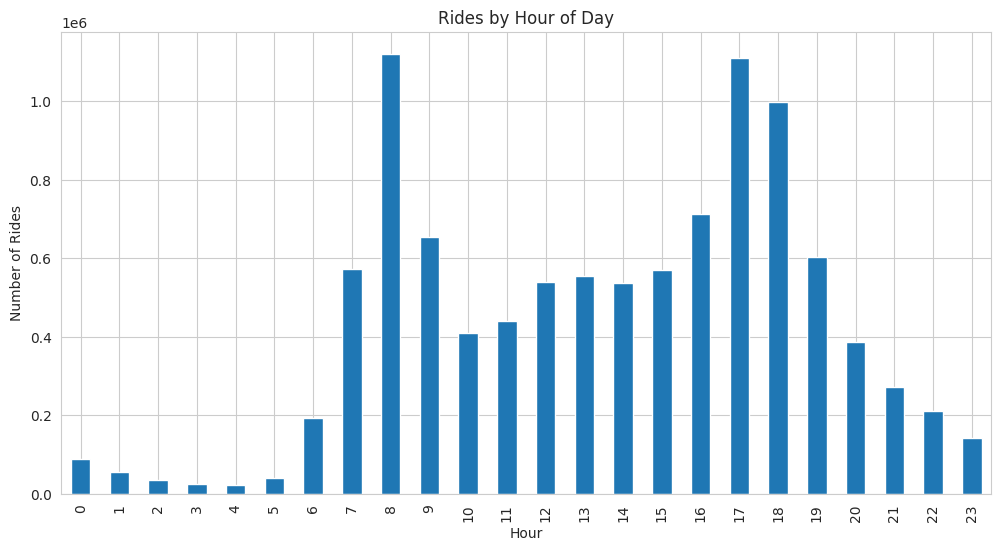

In [ ]:
# Hourly pattern
plt.figure(figsize=(12, 6))
hourly_rides = df_historical.groupby('hour').size()
hourly_rides.plot(kind='bar')
plt.title('Rides by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.show()

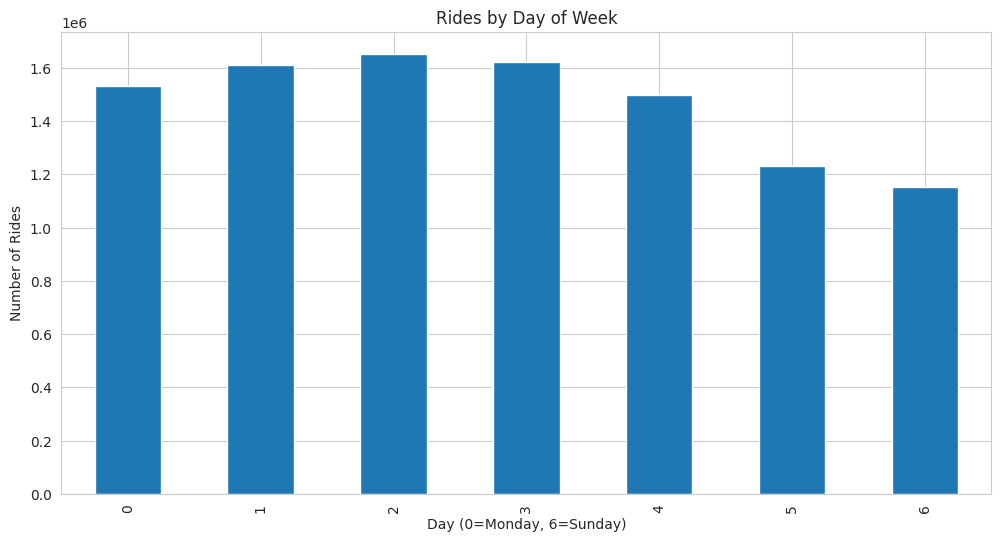

In [ ]:
# Daily pattern

plt.figure(figsize=(12, 6))
daily_rides = df_historical.groupby('day_of_week').size()
daily_rides.plot(kind='bar')
plt.title('Rides by Day of Week')
plt.xlabel('Day (0=Monday, 6=Sunday)')
plt.ylabel('Number of Rides')
plt.show()

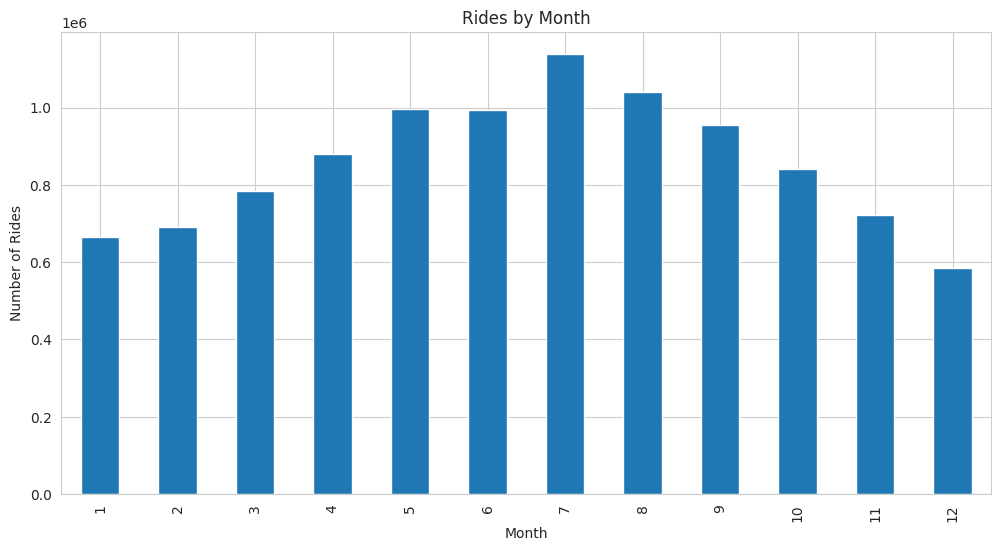

In [ ]:
# Monthly pattern

plt.figure(figsize=(12, 6))
monthly_rides = df_historical.groupby('month').size()
monthly_rides.plot(kind='bar')
plt.title('Rides by Month')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.show()

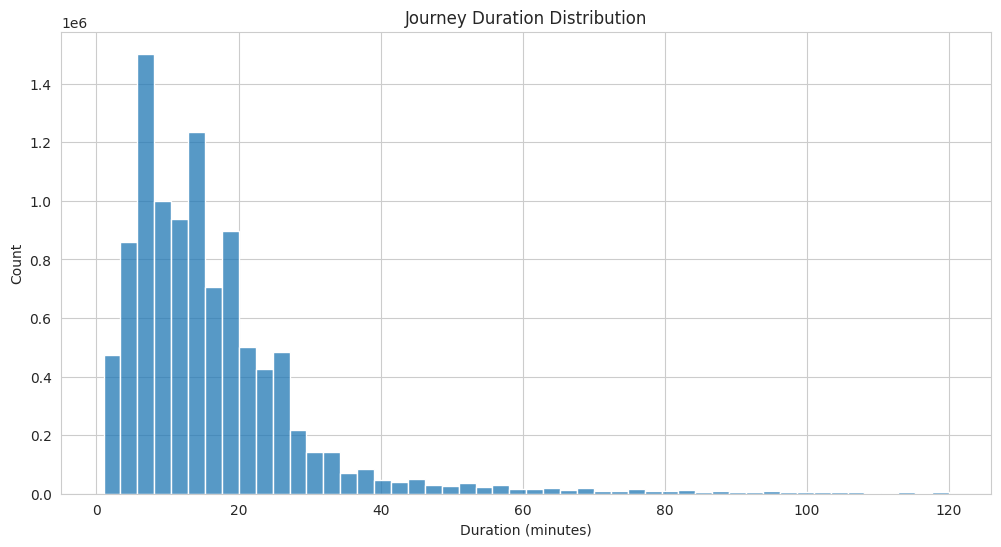

In [ ]:
# Journey Duration Distribution

plt.figure(figsize=(12, 6))
df_historical['duration_minutes'] = df_historical['duration'] / 60
sns.histplot(data=df_historical[df_historical['duration_minutes'] <= 120],
             x='duration_minutes',
             bins=50)
plt.title('Journey Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()

### **Note**
Temporal Patterns in London Bike-Sharing (2019)

**Hourly Usage Patterns**

**Peak Hours:**

Morning Peak: 8AM (1.1M rides)

Evening Peak: 17:00/5PM (~1.1M rides)

**Off-Peak:**

Lowest usage: 2AM-5AM

Mid-day plateau: 10AM-4PM

Pattern indicates:

Strong commuter usage

Clear business hour influence

Minimal night-time activity

**Daily Usage Patterns**

Weekday vs Weekend:

Weekdays (Mon-Fri): Higher consistent usage

Weekends: Significant drop in usage

**Specific Days:**

Highest: Wednesday (1.65M rides)

Lowest: Sunday (1.15M rides)

**Pattern suggests:**

Primary use for commuting

Business day dependency

Weekend leisure usage is lower

**Monthly/Seasonal Patterns**

**Peak Season:**

Highest: July (1.1M rides)

Strong summer usage

**Low Season:**

Winter months (Dec-Feb)

Lowest in December

**Trend:**

Gradual increase Spring→Summer

Gradual decrease Autumn→Winter

Shows clear seasonal influence

**Journey Duration Analysis**

**Typical Journey:**

Most common: 5-20 minutes

Peak duration: 10 minutes

**Distribution:**

Right-skewed distribution

Sharp decline after 20 minutes

Very few rides >60 minutes



In [ ]:
# Additional time features
df_historical['hour_sin'] = np.sin(2 * np.pi * df_historical['hour']/24)  # Cyclical encoding
df_historical['hour_cos'] = np.cos(2 * np.pi * df_historical['hour']/24)
df_historical['peak_hour'] = df_historical['hour'].apply(lambda x: 1 if x in [8,9,17,18] else 0)  # Rush hours
df_historical['part_of_day'] = pd.cut(df_historical['hour'],
                                    bins=[-1,6,12,18,23],
                                    labels=['Night','Morning','Afternoon','Evening'])

In [ ]:
# Additional journey metrics
df_historical['same_station'] = (df_historical['startstation_id'] == df_historical['endstation_id']).astype(int)
df_historical['journey_count_per_day'] = df_historical.groupby(df_historical['start_date'].dt.date)['rental_id'].transform('count')
df_historical['avg_duration_per_day'] = df_historical.groupby(df_historical['start_date'].dt.date)['duration'].transform('mean')


In [ ]:
# Station demand metrics
station_stats = df_historical.groupby('startstation_id').agg({
    'rental_id': 'count',
    'duration': ['mean', 'std'],
    'same_station': 'mean'
}).reset_index()

In [ ]:
station_stats.columns = ['startstation_id', 'total_trips', 'avg_duration', 'duration_std', 'return_rate']

In [ ]:
# Just copy the needed columns, no conversion needed
station_locations = df_stations[['station_id', 'latitude', 'longitude']].copy()

# Do both merges cleanly
df_historical = (df_historical
                .merge(station_stats, on='startstation_id', how='left')
                .merge(station_locations,
                      left_on='startstation_id',
                      right_on='station_id',
                      how='left')
                .drop('station_id', axis=1))  # drop the redundant column

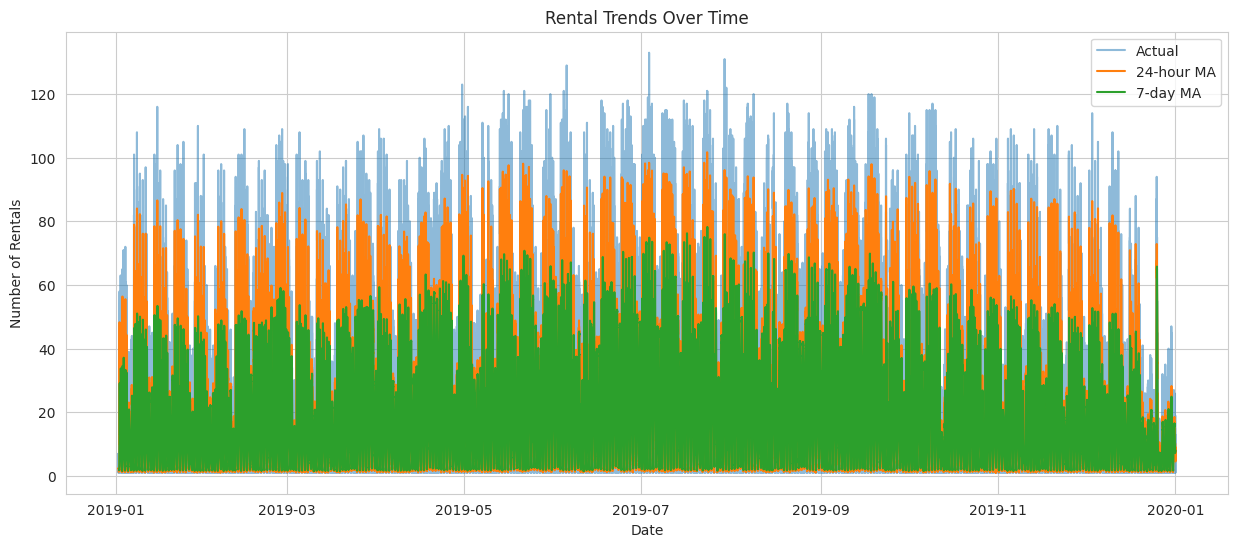

In [ ]:
# Time-based aggregations
hourly_stats = df_historical.groupby(['start_date', 'hour']).agg({
    'rental_id': 'count',
    'duration': 'mean',
    'startstation_id': 'nunique'
}).reset_index()

# Calculate moving averages
hourly_stats['MA_24h'] = hourly_stats['rental_id'].rolling(24).mean()
hourly_stats['MA_7d'] = hourly_stats['rental_id'].rolling(24*7).mean()

# Visualize trends
plt.figure(figsize=(15, 6))
plt.plot(hourly_stats['start_date'], hourly_stats['rental_id'], alpha=0.5, label='Actual')
plt.plot(hourly_stats['start_date'], hourly_stats['MA_24h'], label='24-hour MA')
plt.plot(hourly_stats['start_date'], hourly_stats['MA_7d'], label='7-day MA')
plt.title('Rental Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

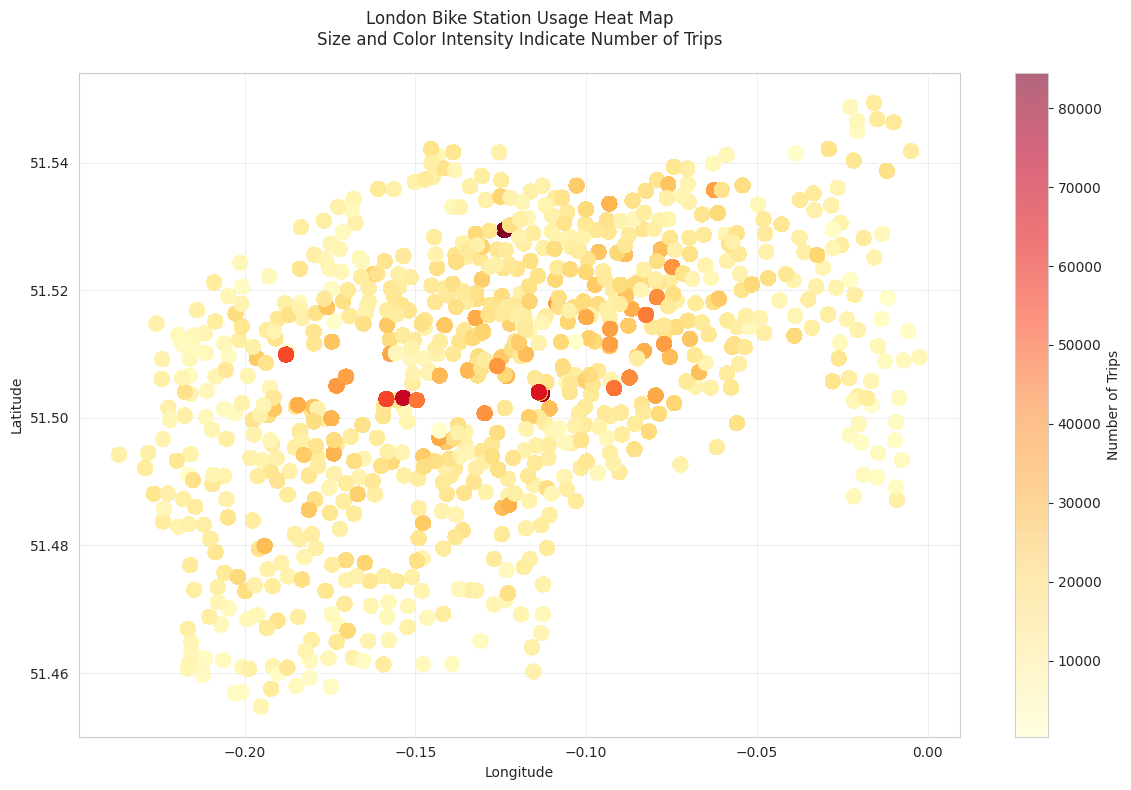

In [ ]:
# Create geographical visualization with improved aesthetics
plt.figure(figsize=(12, 8))
plt.scatter(df_historical['longitude'],
           df_historical['latitude'],
           c=df_historical['total_trips'],
           cmap='YlOrRd',
           alpha=0.6,
           s=100)  # increased point size for better visibility

plt.colorbar(label='Number of Trips')
plt.title('London Bike Station Usage Heat Map\nSize and Color Intensity Indicate Number of Trips', pad=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add grid for better geographical reference
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()